<a href="https://colab.research.google.com/github/joec99/Anomoly_detection_project/blob/main/Anomaly_detection_ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import relevant libraries & load data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# Load the dataset
url = 'https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv'
data = pd.read_csv(url)

# Display the first few rows of the dataset
data.head()


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,682,2.391656,4.617196,2.848982,76.272417,69.884609
1,605,5.466877,6.424361,5.727520,73.222679,74.907314
2,658,3.434232,3.680896,1.678708,88.089916,78.704806
3,749,2.094656,7.120927,1.639670,77.661625,82.386700
4,676,3.538228,5.956472,3.225336,75.226352,67.153220


# Inspect DF and perform EDA

In [ ]:
# Look at spread of data
print(data.describe())

print("\n" + "="*40 + "\n")

# Check for missing values
missing_values = data.isnull().sum()

# Check for duplicate rows
duplicate_rows = data.duplicated().sum()

print("Missing Values:\n", missing_values)

print("\n" + "="*40 + "\n")

print("Duplicate Rows:", duplicate_rows)


         Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
count  19535.000000      19535.000000   19535.000000      19535.000000   
mean     791.239263          3.303775       6.655615          2.335369   
std      267.611193          1.021643       2.761021          1.036382   
min       61.000000          0.003384       0.003187          0.002483   
25%      593.000000          2.518815       4.916886          1.600466   
50%      746.000000          3.162035       6.201720          2.166883   
75%      934.000000          4.055272       7.744973          2.848840   
max     2239.000000          7.265566      21.138326          7.478505   

       lub oil temp  Coolant temp  
count  19535.000000  19535.000000  
mean      77.643420     78.427433  
std        3.110984      6.206749  
min       71.321974     61.673325  
25%       75.725990     73.895421  
50%       76.817350     78.346662  
75%       78.071691     82.915411  
max       89.580796    195.527912  


Missing

## Find 95th percentile and analyse

In [ ]:
# Calculate the 95th percentile for each feature
percentiles_95 = data.quantile(0.95)
percentiles_95

,0.95
Engine rpm,1324.000000
Lub oil pressure,5.058040
Fuel pressure,12.208475
Coolant pressure,4.438415
lub oil temp,84.940778
Coolant temp,88.612891


As a sanity check, calculate the number of datapoints above the 95th percentile for each features:

In [ ]:
# Step 1: Calculate the 95th percentile for each feature - make a copy of data
percentile_95 = data.quantile(0.95)

# Step 2: Identify data points greater than the 95th percentile
over_95 = (data > percentile_95)

# Step 3: Count the number of data points greater than the 95th percentile for each feature
over_95_counts = over_95.sum()

# Display the counts
print("Number of data points > 95th percentile for each feature:")
print(over_95_counts)

Number of data points > 95th percentile for each feature:
Engine rpm          974
Lub oil pressure    977
Fuel pressure       977
Coolant pressure    977
lub oil temp        977
Coolant temp        977
dtype: int64


## Plot features to visually inspect data distributions

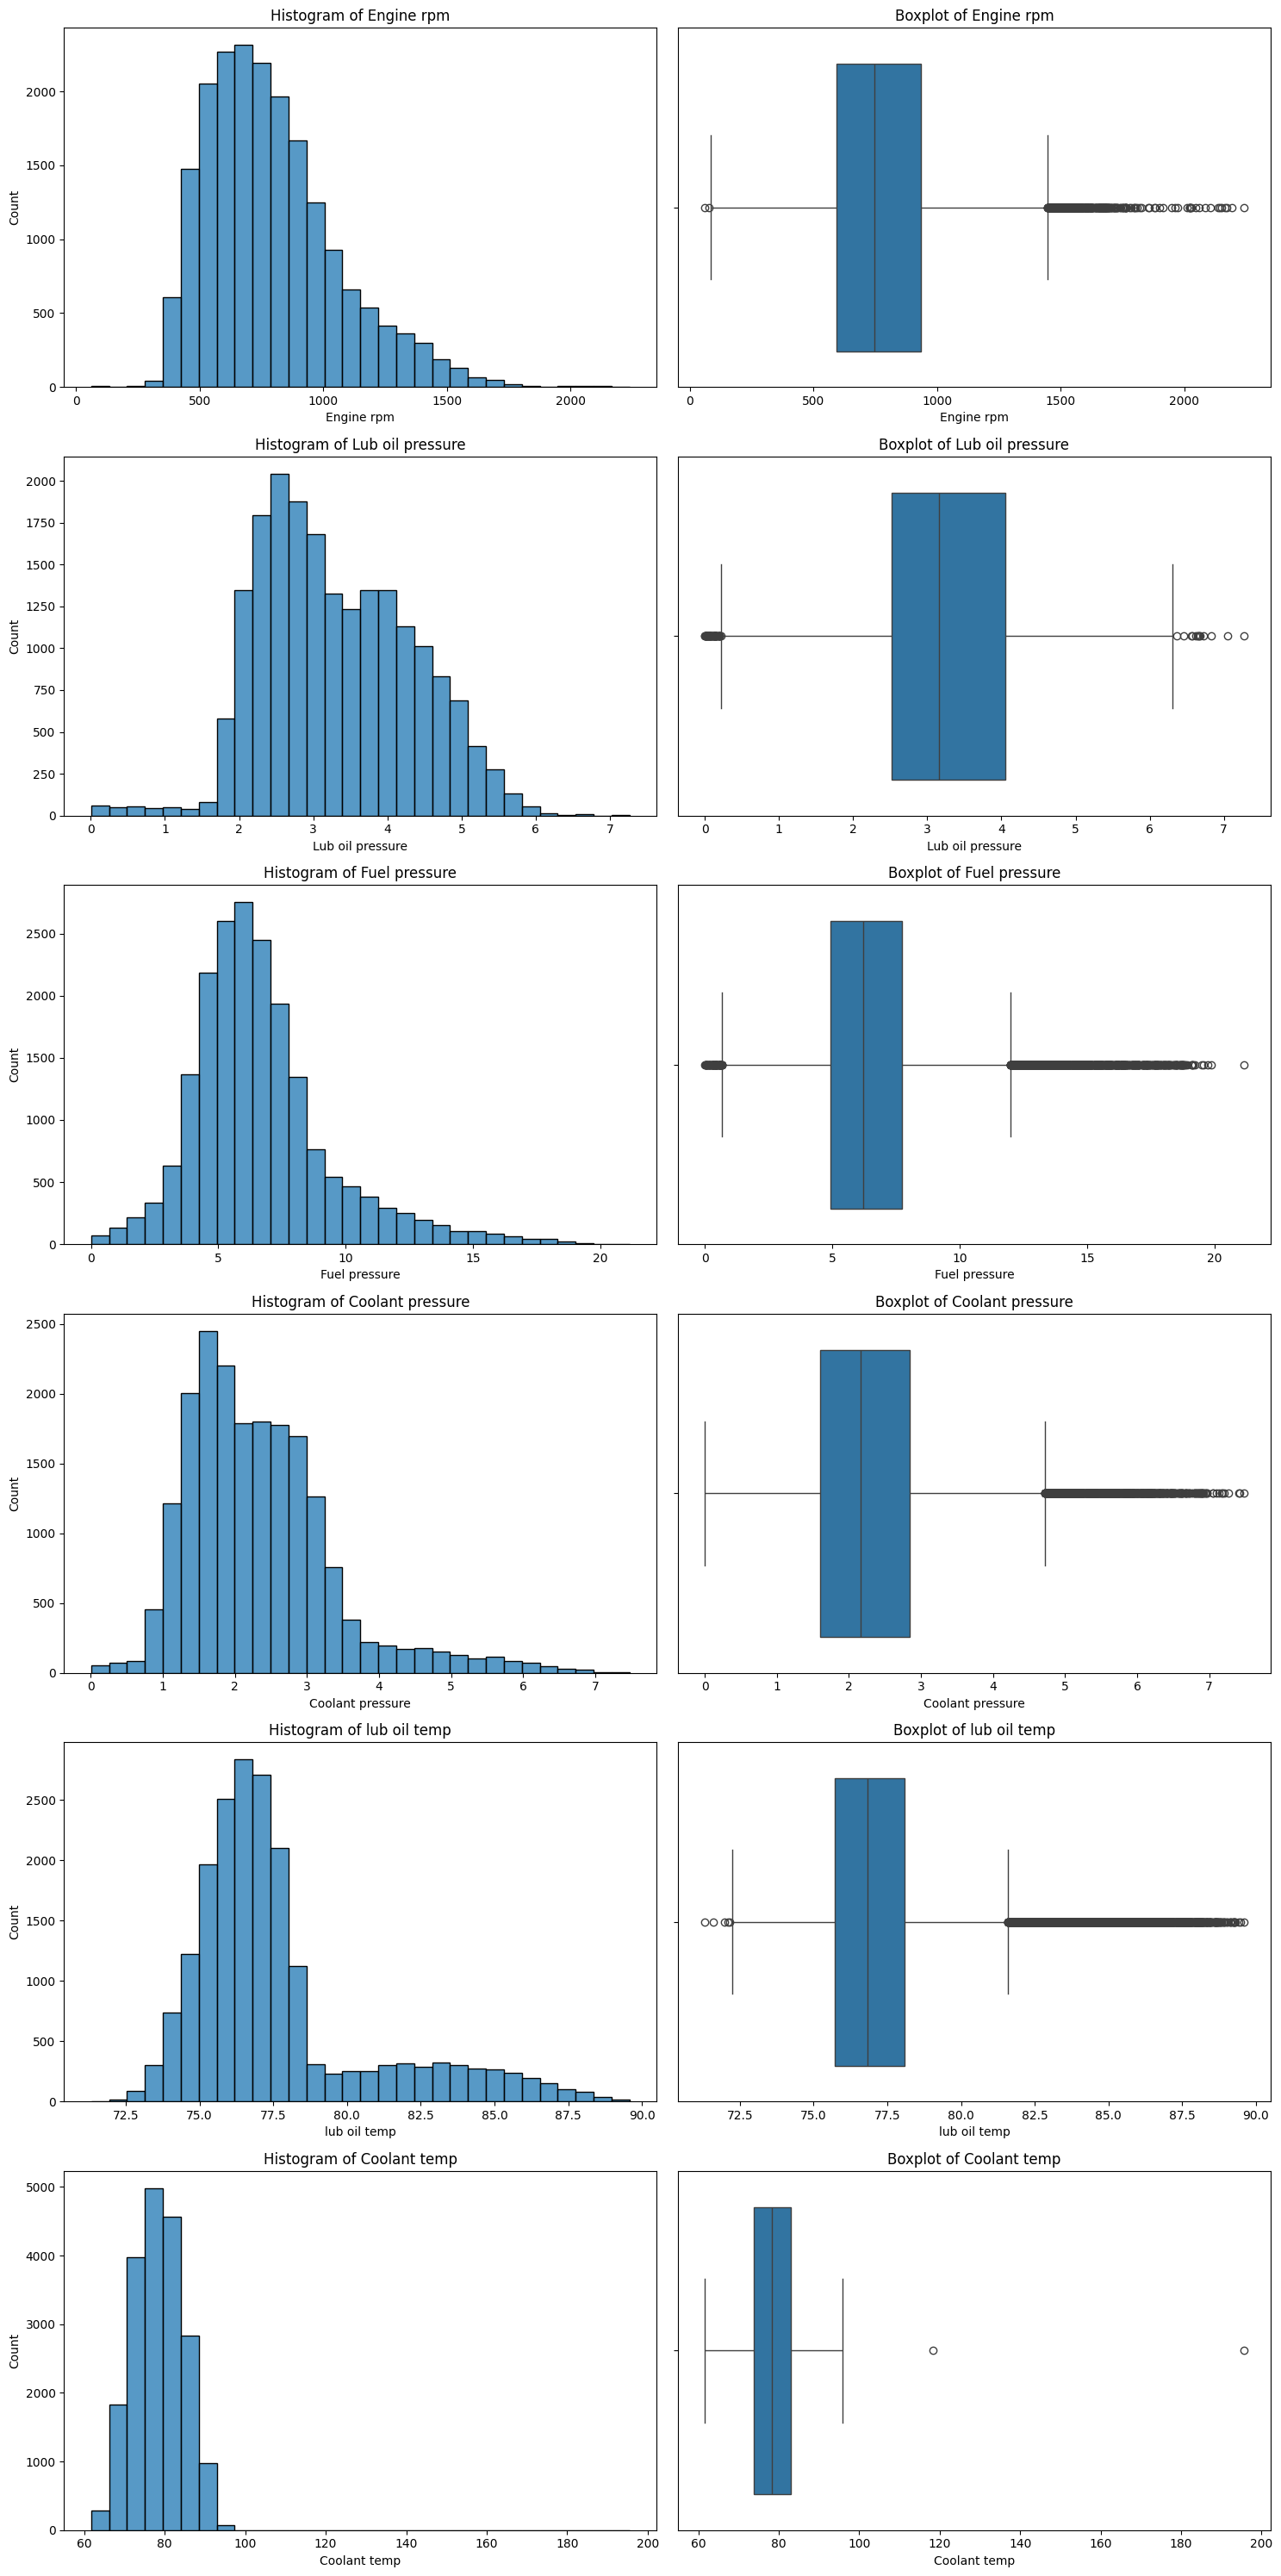

In [ ]:
# Determine the number of columns
num_features = len(data.columns)

# Create subplots with 2 plots for each feature
fig, axes = plt.subplots(num_features, 2, figsize=(15, 5 * num_features))

# Initialize a counter for the subplot index
i = 0

# Iterate over each column in the DataFrame
for column in data.columns:
    # Histogram on the left
    sns.histplot(data[column], bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {column}')

    # Boxplot on the right
    sns.boxplot(x=data[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {column}')

    # Set the same x-scale for both plots
    x_limits = axes[i, 0].get_xlim()
    axes[i, 1].set_xlim(x_limits)

    # increment the counter
    i += 1

# Adjust layout
plt.tight_layout()
plt.show()


Plotting a pairwise correlation plot:

                  Engine rpm  Lub oil pressure  Fuel pressure  \
Engine rpm          1.000000          0.029458      -0.007113   
Lub oil pressure    0.029458          1.000000       0.048723   
Fuel pressure      -0.007113          0.048723       1.000000   
Coolant pressure   -0.034145         -0.013800       0.034158   
lub oil temp        0.063802          0.005934      -0.048913   
Coolant temp        0.030689         -0.060710      -0.052489   

                  Coolant pressure  lub oil temp  Coolant temp  
Engine rpm               -0.034145      0.063802      0.030689  
Lub oil pressure         -0.013800      0.005934     -0.060710  
Fuel pressure             0.034158     -0.048913     -0.052489  
Coolant pressure          1.000000     -0.037137      0.034930  
lub oil temp             -0.037137      1.000000      0.081643  
Coolant temp              0.034930      0.081643      1.000000  


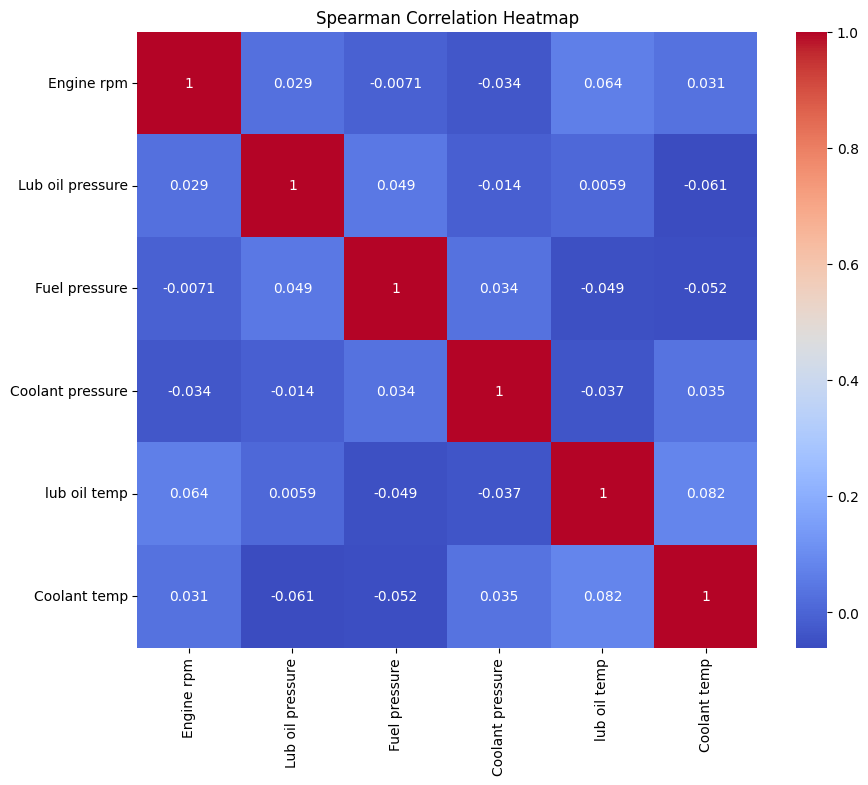

Pearson Correlation Coefficients and P-Values:
                                   Pearson Correlation Coefficient  \
Engine rpm       Lub oil pressure                         0.025046   
                 Fuel pressure                           -0.001571   
                 Coolant pressure                        -0.024979   
                 lub oil temp                             0.052134   
                 Coolant temp                             0.029560   
Lub oil pressure Engine rpm                               0.025046   
                 Fuel pressure                            0.043790   
                 Coolant pressure                        -0.009357   
                 lub oil temp                            -0.008031   
                 Coolant temp                            -0.060906   
Fuel pressure    Engine rpm                              -0.001571   
                 Lub oil pressure                         0.043790   
                 Coolant pressure          

In [ ]:
# find spearman correlation results
spearman_results = data.corr(method='spearman')
print(spearman_results)

# produce heatmap of correlation results
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_results, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Heatmap')
plt.show()

# Calculate Pearson correlation coefficient and p-values
pearson_corr_pval = {}
for col1 in data.columns:
    for col2 in data.columns:
        if col1 != col2:
            corr, p_value = pearsonr(data[col1], data[col2])
            pearson_corr_pval[(col1, col2)] = (corr, p_value)

# Convert to DataFrame for easier reading
pearson_corr_pval_df = pd.DataFrame(pearson_corr_pval, index=['Pearson Correlation Coefficient', 'P-Value']).T
print("Pearson Correlation Coefficients and P-Values:")
print(pearson_corr_pval_df)

Confirm whether data is normally distributed

In [ ]:
# Iterate over each column in the DataFrame and perform Shapiro-Wilk test
for column in data.columns:
    stat, p_value = shapiro(data[column])
    print(f'Shapiro-Wilk Test for {column}:')
    print(f'Statistic={stat:.4f}, p-value={p_value:.4f}')
    if p_value > 0.05:
        print(f'{column} appears to be normally distributed (fail to reject H0)\n')
    else:
        print(f'{column} does not appear to be normally distributed (reject H0)\n')


Shapiro-Wilk Test for Engine rpm:
Statistic=0.9469, p-value=0.0000
Engine rpm does not appear to be normally distributed (reject H0)

Shapiro-Wilk Test for Lub oil pressure:
Statistic=0.9817, p-value=0.0000
Lub oil pressure does not appear to be normally distributed (reject H0)

Shapiro-Wilk Test for Fuel pressure:
Statistic=0.9238, p-value=0.0000
Fuel pressure does not appear to be normally distributed (reject H0)

Shapiro-Wilk Test for Coolant pressure:
Statistic=0.9146, p-value=0.0000
Coolant pressure does not appear to be normally distributed (reject H0)

Shapiro-Wilk Test for lub oil temp:
Statistic=0.8389, p-value=0.0000
lub oil temp does not appear to be normally distributed (reject H0)

Shapiro-Wilk Test for Coolant temp:
Statistic=0.9825, p-value=0.0000
Coolant temp does not appear to be normally distributed (reject H0)



/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19535.
  res = hypotest_fun_out(*samples, **kwds)


# Performing anomoly detecton with a statistical method: IQR

## Build a function to identify outliers with the IQR method

In [ ]:
def detect_outliers_iqr(df):

    outliers = pd.DataFrame(index=df.index)

    for col in df.columns:
        # Calculate the 25th and 75th percentiles
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)

        # Calculate the IQR
        IQR = Q3 - Q1
        outlier = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))

        outliers[col + '_outlier'] = outlier.astype(int) # ensure suffix for furture concat

    return outliers

# creating a new dataframe from the function built
outliers_iqr = detect_outliers_iqr(data)

# concatenate this dataframe with the original (columns have _outlier suffix)
dataframes_to_concat = [data, outliers_iqr]
data_concat = pd.concat(dataframes_to_concat, axis=1)

# Add a column to indicate samples with two or more features as outliers
data_concat['anomaly_iqr'] = outliers_iqr.sum(axis=1) >= 2

print("\n" + "="*40 + "\n")

# Display the updated DataFrame
print(data_concat.head())

print("\n" + "="*40 + "\n")

# Display anomalies
print(data_concat[data_concat['anomaly_iqr'] == True])

print("\n" + "="*40 + "\n")

print(data_concat['anomaly_iqr'].value_counts())





   Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0         682          2.391656       4.617196          2.848982   
1         605          5.466877       6.424361          5.727520   
2         658          3.434232       3.680896          1.678708   
3         749          2.094656       7.120927          1.639670   
4         676          3.538228       5.956472          3.225336   

   lub oil temp  Coolant temp  Engine rpm_outlier  Lub oil pressure_outlier  \
0     76.272417     69.884609                   0                         0   
1     73.222679     74.907314                   0                         0   
2     88.089916     78.704806                   0                         0   
3     77.661625     82.386700                   0                         0   
4     75.226352     67.153220                   0                         0   

   Fuel pressure_outlier  Coolant pressure_outlier  lub oil temp_outlier  \
0                      0              

### Calculating the proportion of anomolous observations detected

In [ ]:
# Calculate the proportion of anomalies (i.e., where 'anomaly_iqr' is True or 1 - this is when 2 features are anomolous)
anomaly_count = data_concat['anomaly_iqr'].value_counts().get(True, 0)
anomaly_proportion = anomaly_count / len(data_concat)

# Check if the result is within the 1-5% range
if 0.01 <= anomaly_proportion <= 0.05:
    print("The result is in the 1-5% range")
else:
    print("The result is not in the 1-5% range")


The result is in the 1-5% range


### Confirming the optimal number of co-occurent anomalies using IQR given the 1-5% expected anomamly rate.

In [ ]:
def calculate_outlier_percentage(data, min_features):

    # Count the number of features that are flagged as outliers (sum across columns)
    outlier_sum = data_concat.filter(like='_outlier').sum(axis=1)

    # Identify samples with at least `min_features` flagged as outliers
    outliers = outlier_sum >= min_features

    # Calculate the percentage of outliers
    percentage_outliers = outliers.sum() / len(data) * 100

    return percentage_outliers

# Iterate over different thresholds (e.g., at least 1, 2, 3 features, etc.)
for min_features in range(1, len(data_concat.filter(like='_outlier').columns) + 1):
    percentage = calculate_outlier_percentage(data_concat, min_features)
    print(f"At least {min_features} feature(s) flagged: {percentage:.7f}% of samples classified as outliers")

    if 1 <= percentage <= 5:
        print(f"This condition meets the 1-5% criterion: At least {min_features} feature(s) must be flagged.\n")


At least 1 feature(s) flagged: 23.7317635% of samples classified as outliers
At least 2 feature(s) flagged: 2.1602252% of samples classified as outliers
This condition meets the 1-5% criterion: At least 2 feature(s) must be flagged.

At least 3 feature(s) flagged: 0.0563092% of samples classified as outliers
At least 4 feature(s) flagged: 0.0000000% of samples classified as outliers
At least 5 feature(s) flagged: 0.0000000% of samples classified as outliers
At least 6 feature(s) flagged: 0.0000000% of samples classified as outliers


The percentage of samples identified as outliers based on the number of features flagged is as follows:
1 Feature: The proportion is 23.73%, which exceeds the expected 1-5% outlier range.
2 Features: The proportion is 2.16%, which falls within the expected 1-5% outlier range.
3 or more Features: The proportion is well below the expected 1-5% outlier range.

**Best Number of Features to Flag**: The best number of features that should contain outlier observations to meet the 1-5% outlier expectation is 2 features.
Reason: When you require at least 2 features to be flagged as outliers, 2.16% of the samples are classified as outliers, which is within the desired 1-5% range.
This means that to correctly identify outliers while keeping the percentage of outliers within the expected 1-5% range, a sample should be classified as an outlier if at least 2 features are flagged as outliers using the IQR method.

# Performing Anomoly detection with ML Models

## Performing one-class SVM for anomoly detection

### Standardising data for one-class SVM model


In [ ]:
# create a new, scaled dataframe for SVM, keep the old dataframe for isolation forest
X = data.copy()

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)

[[-0.40821185 -0.89281929 -0.73830371  0.49559555 -0.44070891 -1.37641176]
 [-0.69595007  2.11733175 -0.08375911  3.27315389 -1.42104681 -0.56715821]
 [-0.49789649  0.12769669 -1.07742594 -0.63362488  3.35802552  0.04469003]
 ...
 [-0.65484461  0.00614053 -1.03874489  3.53706979 -0.56369786 -1.00013427]
 [ 1.38921787 -0.55994531 -1.06920452  0.59469502 -0.27605939  0.47895143]
 [-0.35963266 -0.77199786 -0.10871387  0.34080808 -0.02812746 -1.17155345]]


### Initial Model Build with OC-SVM




In [ ]:
# Initialise the one-class SVM model
model = OneClassSVM(kernel = 'rbf', nu = 0.05, gamma=0.1)
# fit the data to the model.
model.fit(X_scaled)

OneClassSVM(gamma=0.1, nu=0.05)

In [ ]:
# Use model to preduct the class
y_pred_svm = model.predict(X_scaled)
print(y_pred_svm)
print('Data type:', type(y_pred_svm))

# find number of anoms with SVM method
anoms_sum = (y_pred_svm == -1).sum()
print('Number of anomalies:', anoms_sum)

# Check in 1-5% range:
if 0.01 <= anoms_sum / len(y_pred_svm) < 0.05:
    print("The result is in the 1-5% range")

print("Percentage of anomalies:", anoms_sum / len(y_pred_svm) * 100) # this is just on the brink!!

print("\n" + "="*40 + "\n")

# create a dataframe for convenience
df_view = pd.DataFrame(X_scaled, columns=X.columns)
df_view['anomaly'] = y_pred_svm
print(df_view.head)
print(df_view.head())

print("\n" + "="*40 + "\n")

# view anomaly-only dataframe
print('The anomalous dataframe to be passed on to ships engineers:')
print(df_view[df_view['anomaly'] == -1])
print("\n" + "="*40 + "\n")

# Check for overlap between anomalies identified by SVM (-1) and IQR method (True)
overlap = df_view[(df_view['anomaly'] == -1) & (data_concat['anomaly_iqr'] == True)]

# Print the number of overlapping anomalies
print("Number of overlapping anomalies between SVM and IQR:", len(overlap))

# Calculate the percentage of SVM anomalies that overlap with IQR anomalies
svm_anomalies_count = len(df_view[df_view['anomaly'] == -1])
iqr_anomalies_count = len(data_concat[data_concat['anomaly_iqr'] == True])
overlap_percentage = len(overlap) / iqr_anomalies_count * 100 if iqr_anomalies_count > 0 else 0

print(f"Percentage of SVM anomalies that overlap with IQR anomalies: {overlap_percentage:.2f}%")

[ 1 -1  1 ...  1  1  1]
Data type: <class 'numpy.ndarray'>
Number of anomalies: 978
Percentage of anomalies: 5.006398771435884


<bound method NDFrame.head of        Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0       -0.408212         -0.892819      -0.738304          0.495596   
1       -0.695950          2.117332      -0.083759          3.273154   
2       -0.497896          0.127697      -1.077426         -0.633625   
3       -0.157842         -1.183534       0.168533         -0.671293   
4       -0.430633          0.229492      -0.253226          0.858747   
...           ...               ...            ...               ...   
19530   -0.411949          0.288774       0.233701         -1.208058   
19531   -0.789372         -1.038290      -0.511826         -0.833709   
19532   -0.654845          0.006141      -1.038745          3.537070   
19533    1.389218         -0.559945      -1.069205          0.594695   
19534   -0.359633         -0.771998      -0.10871

Using the initial SVM model hyperparameters, we see just over 5% of observations being classed as anomalous. Thus, post viusalisation with PCA, we need to tune the model.

### Visualising with PCA

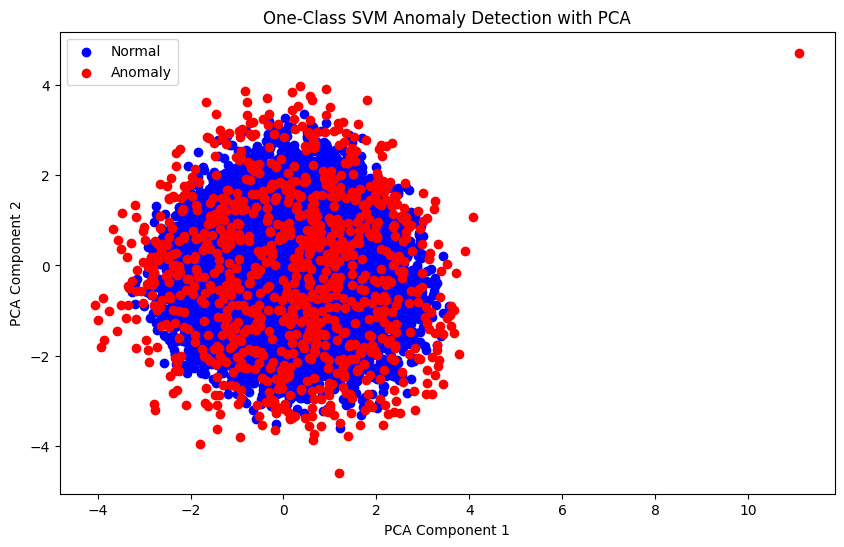

In [ ]:
# Use PCA to reduce to 2D for visualization - data should be standardised
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for visualization
df_svm = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_svm['anomaly'] = y_pred_svm

plt.figure(figsize=(10, 6))
plt.scatter(df_svm[df_svm['anomaly'] == 1]['PCA1'], df_svm[df_svm['anomaly'] == 1]['PCA2'],
            c='blue', label='Normal')
plt.scatter(df_svm[df_svm['anomaly'] == -1]['PCA1'], df_svm[df_svm['anomaly'] == -1]['PCA2'],
            c='red', label='Anomaly')
plt.title("One-Class SVM Anomaly Detection with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [ ]:
# What features were chosen via PCA for the SVM model:
components_svm = pca.components_
features_svm = np.array(data.columns)[np.abs(components_svm).argsort()[::-1][:, :2]]
# Show explained variance of each feature
explained_variance_svm = pca.explained_variance_ratio_

# Print the results
print("One-Class SVM PCA:")
print("Features contributing to the 2 PCA components:\n", features_svm)
print("Explained variance by the 2 components:", explained_variance_svm)

One-Class SVM PCA:
Features contributing to the 2 PCA components:
 [['Fuel pressure' 'Coolant temp']
 ['Coolant pressure' 'Engine rpm']]
Explained variance by the 2 components: [0.1899485  0.17692968]


**Interpretation**:

**PC1**:

The first principal component is primarily influenced by 'Fuel pressure' and 'Coolant temp'.

This suggests that the combination of 'Fuel pressure' and 'Coolant temp' captures the most variance in the data (though still relatively low at 18.99%).

If anomalies are spread along this component, it indicates that unusual values in 'Fuel pressure' and 'Coolant temp' might be key indicators of engine anomalies.

**PC2**:

The second principal component is primarily influenced by 'Coolant pressure' and 'Engine rpm'.

This suggests that the combination of 'Coolant pressure' and 'Engine rpm' captures the next highest amount of variance (17.69%).

If anomalies are spread along this component, it indicates that unusual values in 'Coolant pressure' and 'Engine rpm' might also be critical in identifying anomalies.

### Hyperparameter optimisation: anomaly proportion

**In this section we are defining the 'best' model as the one that yeilds a middle of the road result in anomaly proportion between 1-5%. In reality, I would consult with the ships engineers and other subject matter experts.**

In [ ]:
# Define a function to evaluate the model with given nu and gamma
def evaluate_model(nu, gamma):
    model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
    model.fit(X_scaled)
    y_pred_svm = model.predict(X_scaled)
    anoms = y_pred_svm == -1
    anomaly_percentage = anoms.sum() / len(y_pred_svm)
    return nu, gamma, anomaly_percentage, model

# Decided to not loop through combinations and it was too computationally expensive
# Setting nu and looping through gamma instead.

# Set the value for 'nu'
nu = 0.03  # Target of 3% max anomaly rate
gamma_values = np.logspace(-3, 1, 5)  # Range of gamma values to test

# Create a list to store the results
results = []

for g in gamma_values:
    # Call the function with the selected nu and gamma
    nu, g, anomaly_percentage, model = evaluate_model(nu, g)

    # Check if the percentage is within the 1-5% range
    if 0.01 <= anomaly_percentage <= 0.05:
        print(f"nu: {nu}, gamma: {g} -> Anomaly percentage: {anomaly_percentage * 100:.2f}%")
    else:
        print(f"nu: {nu}, gamma: {g} -> Anomaly percentage is out of the desired range: {anomaly_percentage * 100:.2f}%")

    # Store the result
    results.append((nu, g, anomaly_percentage))

nu: 0.03, gamma: 0.001 -> Anomaly percentage: 2.99%
nu: 0.03, gamma: 0.01 -> Anomaly percentage: 3.00%
nu: 0.03, gamma: 0.1 -> Anomaly percentage: 3.00%
nu: 0.03, gamma: 1.0 -> Anomaly percentage is out of the desired range: 9.52%
nu: 0.03, gamma: 10.0 -> Anomaly percentage is out of the desired range: 57.42%
nu: 0.03, gamma: 0.001 -> Anomaly percentage: 2.99%
nu: 0.03, gamma: 0.01 -> Anomaly percentage: 3.00%
nu: 0.03, gamma: 0.1 -> Anomaly percentage: 3.00%
nu: 0.03, gamma: 1.0 -> Anomaly percentage: 9.52%
nu: 0.03, gamma: 10.0 -> Anomaly percentage: 57.42%


Given the above results and the fact that gamma values between 0.01-1 are common, we will choose model parameters of gamma = 0.03 and nu = 0.01

Number of anomalies: 586
Number of overlapping anomalies between SVM and IQR: 148
Percentage of SVM anomalies that overlap with IQR anomalies: 25.26%


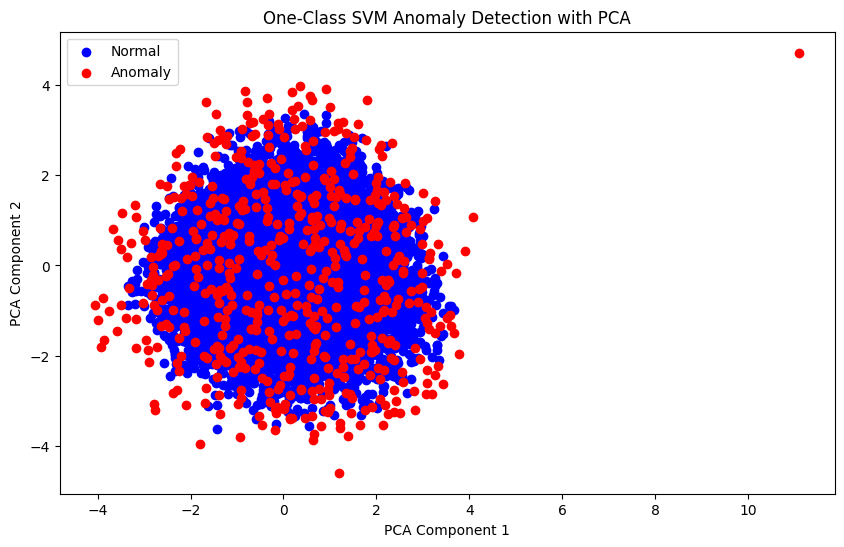

In [ ]:
# Use the best model found in prior section
#y_pred_best_svm = best_model.predict(X_scaled)
y_pred_best_svm = OneClassSVM(kernel = 'rbf', nu = 0.03, gamma=0.01).fit(X_scaled).predict(X_scaled)

# Find number of anomalies with the best SVM model
anoms_sum = (y_pred_best_svm == -1).sum()
print('Number of anomalies:', anoms_sum)

# Create a DataFrame with the best SVM model
df_view_best = pd.DataFrame(X_scaled, columns=X.columns)
df_view_best['anomaly'] = y_pred_best_svm

# For the best params found, check overlap with IQR anomalies
overlap = df_view_best[(df_view_best['anomaly'] == -1) & (data_concat['anomaly_iqr'] == True)]

# Print the number of overlapping anomalies
print("Number of overlapping anomalies between SVM and IQR:", len(overlap))

# Calculate the percentage of SVM anomalies that overlap with IQR anomalies
svm_anomalies_count = len(df_view_best[df_view_best['anomaly'] == -1])
overlap_percentage = len(overlap) / svm_anomalies_count * 100 if svm_anomalies_count > 0 else 0

print(f"Percentage of SVM anomalies that overlap with IQR anomalies: {overlap_percentage:.2f}%")

# Apply PCA to visualize the anomalies
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for visualization
df_svm = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_svm['anomaly'] = y_pred_best_svm

plt.figure(figsize=(10, 6))
plt.scatter(df_svm[df_svm['anomaly'] == 1]['PCA1'], df_svm[df_svm['anomaly'] == 1]['PCA2'],
            c='blue', label='Normal')
plt.scatter(df_svm[df_svm['anomaly'] == -1]['PCA1'], df_svm[df_svm['anomaly'] == -1]['PCA2'],
            c='red', label='Anomaly')
plt.title("One-Class SVM Anomaly Detection with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


## Performing anomaly detection with isolation forests

In [ ]:
# Initialize the Isolation Forest model with base hyperparameters
iso_forest = IsolationForest(
    n_estimators=100,    # Number of trees in the forest
    max_samples=1.0,     # Use the entire dataset to build each tree
    contamination=0.03,  # Expect a maximum of 3% of the data to be outliers
    random_state=42      # For reproducibility
)

# Fit the model to the scaled data
iso_forest.fit(X) # non-scaled data!!

# Predict the anomalies
y_pred_iforest = iso_forest.predict(X)

# Count the number of anomalies
anoms_iforest = y_pred_iforest == -1
anomaly_percentage_iforest = anoms_iforest.sum() / len(y_pred_iforest)

print(f"Number of anomalies detected by Isolation Forest: {anoms_iforest.sum()}")
print(f"Percentage of anomalies detected by Isolation Forest: {anomaly_percentage_iforest * 100:.2f}%")

# create a dataframe from iforest result
df_view_iforest = pd.DataFrame(X, columns=X.columns)
df_view_iforest['anomaly'] = y_pred_iforest
df_view_iforest.head()

print("\n" + "="*40 + "\n")

# view anomaly-only dataframe
print('The anomalous dataframe to be passed on to ships engineers:')
df_view_iforest[df_view_iforest['anomaly'] == -1]



Number of anomalies detected by Isolation Forest: 587
Percentage of anomalies detected by Isolation Forest: 3.00%


The anomalous dataframe to be passed on to ships engineers:


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,-1
9,806,3.946885,21.138326,1.572569,74.923316,72.112692,-1
17,1312,5.963439,7.563578,5.931953,77.738876,88.661972,-1
115,61,3.936641,8.088475,1.845086,77.227211,74.088200,-1
144,1762,1.697487,4.327845,2.523372,86.750349,82.393211,-1
...,...,...,...,...,...,...,...
19314,442,2.907188,10.851772,1.341304,86.290646,71.262642,-1
19328,771,3.916701,5.136610,5.592643,85.757119,69.278462,-1
19334,1084,4.426314,11.785500,2.959202,87.426879,79.655316,-1
19370,740,2.792556,11.359028,1.580190,88.791884,70.047659,-1


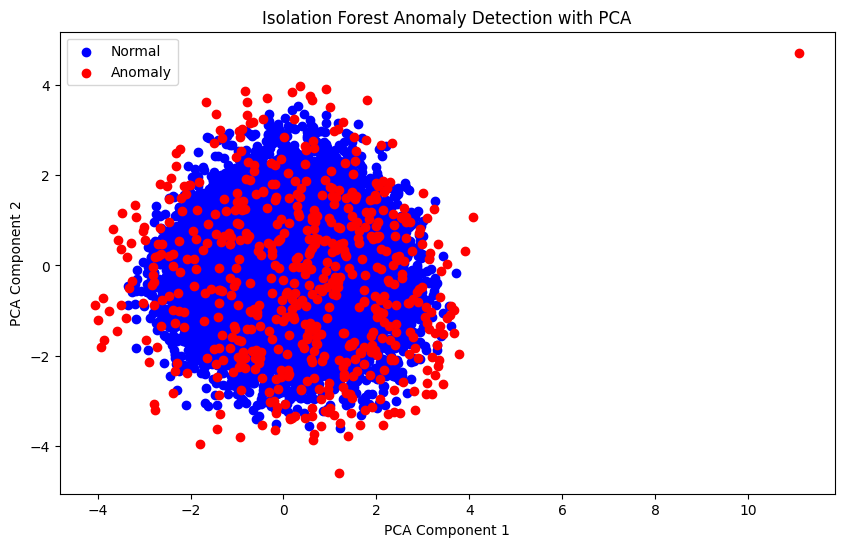

In [ ]:
# Step 1: Apply PCA to reduce the data to 2 components
pca = PCA(n_components=2)
data_pca = pca.fit_transform(X)

# Create a DataFrame with PCA components and anomaly labels
df_iforest = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_iforest['anomaly'] = y_pred_iforest

# Plot PCA wit Iforest anomoly model
plt.figure(figsize=(10, 6))
plt.scatter(df_iforest[df_iforest['anomaly'] == 1]['PCA1'], df_iforest[df_iforest['anomaly'] == 1]['PCA2'],
            c='blue', label='Normal')
plt.scatter(df_iforest[df_iforest['anomaly'] == -1]['PCA1'], df_iforest[df_iforest['anomaly'] == -1]['PCA2'],
            c='red', label='Anomaly')
plt.title("Isolation Forest Anomaly Detection with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()



### Exploring various hyperparameters for Iforest model:


**The base case led to an acceptable result - the following analysis is just for exploration!**

In [ ]:
# Define the range of values to test for 'n_estimators' and 'max_samples'
n_estimators_values = [50, 100, 200]
max_samples_values = [0.5, 0.75, 1.0]

# Store the best model and parameters
best_model = None
best_n_estimators = None
best_max_samples = None
best_percentage = None

# Loop through all combinations of 'n_estimators' and 'max_samples' - (ON^2) so takes a while
for n_estimators in n_estimators_values:
    for max_samples in max_samples_values:

        # Initialize the model with the current 'n_estimators' and 'max_samples'
        model = IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=0.02, random_state=42)

        # Fit the model
        model.fit(X_scaled)

        # Predict the anomalies
        y_pred_iforest = model.predict(X_scaled)

        # Calculate the percentage of anomalies
        anoms = y_pred_iforest == -1
        anomaly_percentage = anoms.sum() / len(y_pred_iforest)
        num_anomalies = anoms.sum()

        # Print the number and percentage of anomalies
        print(f"n_estimators: {n_estimators}, max_samples: {max_samples} -> Number of anomalies: {num_anomalies}, Anomaly percentage: {anomaly_percentage * 100:.2f}%")


n_estimators: 50, max_samples: 0.5 -> Number of anomalies: 391, Anomaly percentage: 2.00%
n_estimators: 50, max_samples: 0.75 -> Number of anomalies: 391, Anomaly percentage: 2.00%
n_estimators: 50, max_samples: 1.0 -> Number of anomalies: 391, Anomaly percentage: 2.00%
n_estimators: 100, max_samples: 0.5 -> Number of anomalies: 391, Anomaly percentage: 2.00%
n_estimators: 100, max_samples: 0.75 -> Number of anomalies: 391, Anomaly percentage: 2.00%
n_estimators: 100, max_samples: 1.0 -> Number of anomalies: 391, Anomaly percentage: 2.00%
n_estimators: 200, max_samples: 0.5 -> Number of anomalies: 391, Anomaly percentage: 2.00%
n_estimators: 200, max_samples: 0.75 -> Number of anomalies: 391, Anomaly percentage: 2.00%
n_estimators: 200, max_samples: 1.0 -> Number of anomalies: 391, Anomaly percentage: 2.00%


In the context of this task, adjusting max_samples and n_estimators had no effect from an anomalous proportion observed perspective - although I am sure that if visualised there would be.

In this example setting contamination to 2% was they key parameter.

### Checking for anomalous observation overlap between OCSVM and iForest methods

In [ ]:
# Check for overlap between anomalies identified by iforest (-1) and IQR method (True)
overlap = df_view_iforest[(df_view_iforest['anomaly'] == -1)  & (data_concat['anomaly_iqr'] == True)]

# Print the number of overlapping anomalies
print("Number of overlapping anomalies between SVM and IQR:", len(overlap))

# Calculate the percentage of iforest anomalies that overlap with IQR anomalies (422)
iqr_anomalies_count = len(data_concat[data_concat['anomaly_iqr'] == True])
overlap_percentage = len(overlap) / iqr_anomalies_count * 100

print(f"Percentage of SVM anomalies that overlap with IQR anomalies: {overlap_percentage:.2f}%")

# Check for overlap between anomalies identified by SVM (-1) and iforest method (-1)
overlap = df_view_best[(df_view_best['anomaly'] == -1) & (df_view_iforest['anomaly'] == -1)]

# Print the number of overlapping anomalies
print("Number of overlapping anomalies between SVM and Iforest:", len(overlap))

# Calculate the percentage of SVM anomalies that overlap with IQR anomalies
iforest_anomalies_count = len(df_view_iforest[df_view_iforest['anomaly'] == -1])
overlap_percentage = (len(overlap) / iforest_anomalies_count) * 100

print(f"Percentage of SVM anomalies that overlap with Iforest anomalies: {overlap_percentage:.2f}%")

Number of overlapping anomalies between SVM and IQR: 222
Percentage of SVM anomalies that overlap with IQR anomalies: 52.61%
Number of overlapping anomalies between SVM and Iforest: 376
Percentage of SVM anomalies that overlap with Iforest anomalies: 64.05%


So even though we identified nearly exactly the same number of anomalies with OCSVM (586) & Iforest methods (587), **we observe that less than half** the observations identified as anomolies by the two methods are the same!

# Reflect

The notebook presents a robust initial approach to anomaly detection within a ship's engine dataset, leveraging both One-Class SVM and Isolation Forest models. The consistent anomaly detection results across various parameter settings suggest that the identified anomalies are well-defined and robust to changes in the modeling approach. The application of PCA is intended to aid in visualizing and interpreting the anomalies; however, the 2D projections provided by PCA may limit the ability to fully capture the complexity of the dataset, as the anomalies do not appear to form distinct clusters or groups in the visualizations. This could indicate that the anomalies are more subtle and dispersed across multiple dimensions, making them less discernible in a two-dimensional space. Despite this limitation, the insights gained from the analysis are valuable for stakeholders, as they offer a foundation for refining maintenance strategies and reducing operational downtime in the shipping industry. Further exploration using higher-dimensional analysis or alternative visualization techniques could enhance the understanding of how these anomalies manifest within the broader dataset.

### Reference:
Devabrat, M., 2022. Predictive Maintenance on Ship's Main Engine using AI. Available at: https://dx.doi.org/10.21227/g3za-v415. [Accessed 5 March 2024]